<a href="https://colab.research.google.com/github/johanhoffman/crocodile-heart/blob/master/Brinkman_NSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the code

In [0]:
# Copyright (C) 2019 Johan Hoffman (jhoffman@kth.se)

# Setup environment

In [55]:
# Setup FEniCS environment 
from google.colab import files

try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common 
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot
import matplotlib.pyplot as plt

import time 

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

dolfin version: 2019.1.0


# Define domain and mesh

In [0]:
# Define domain
L = 4
H = 1

# Define subdomains
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0) 

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)
      
left = Left()
right = Right()
lower = Lower()
upper = Upper()

resolution = 32

# Generate mesh 
mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)

# Define mesh functions 
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

# Define approximation spaces

In [0]:
# Generate finite element spaces
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)
K = FunctionSpace(mesh, "Discontinuous Lagrange", 0)

# Define trial and test functions 
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

# Define boundary conditions

In [0]:
# Define boundary conditions 
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return bool(x[1] < DOLFIN_EPS and on_boundary)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return bool(x[1] > (H - DOLFIN_EPS) and on_boundary)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return bool(x[0] < DOLFIN_EPS and on_boundary)

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return bool(x[0] > (L - DOLFIN_EPS) and on_boundary)

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()

uin = 1.0
bcuin = DirichletBC(V, (uin, 0.0), dbc_left)
bcuw0 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcuw1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
#bcuw0 = DirichletBC(V, (0.0, 0.0), dbc_lower)
#bcuw1 = DirichletBC(V, (0.0, 0.0), dbc_upper)

p0 = 0.0
p1 = 0.0
bcp0 = DirichletBC(Q, p0, dbc_left) 
bcp1 = DirichletBC(Q, p1, dbc_right)

bcu = [bcuin, bcuw0, bcuw1]
bcp = [bcp1]

# Define method parameters

In [0]:
# Define functions
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# Set model parameters
#k = Expression('x[1]', element = K.ufl_element())
#k = Expression('x[0]*x[1]*(1.0 - x[1])*(4.0-x[0])', element = K.ufl_element())
k = Expression('1.0e-2 + fabs(sin(2*pi*x[1]))', element = K.ufl_element())
nu = 1.0e-2

# Set method parameters
num_nnlin_iter = 5 
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default" 

# Time step length 
dt = 0.5*mesh.hmin() 

# Parameters for numerical stabilizatio
d1 = 1*mesh.hmin()
d2 = 1*mesh.hmin()
d3 = 1e-2*mesh.hmin()

# Define measure for boundary inntegration  
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# Define varitional problem

In [0]:
# Define variational problems
Fu = (1/dt)*inner(u - u0, v)*dx - p1*div(v)*dx \
     + nu*inner(grad(u), grad(v))*dx \
     + inner(grad(u)*u1, v)*dx \
     + d1*inner(grad(u)*u1, grad(v)*u1)*dx \
     + d2*div(u)*div(v)*dx
au = lhs(Fu)
Lu = rhs(Fu)

ap = d1*dot(grad(p), grad(q))*dx # + d3*p*q*dx 
Lp = - div(u1)*q*dx 

# Assemble linear matrix 
#Ap = assemble(ap)

# Set I/O variables

In [0]:
# Open files
file_u = File("results-BNS/u.pvd")
file_p = File("results-BNS/p.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 10

# Time stepping algorithm

Calling FFC just-in-time (JIT) compiler, this may take some time.
Time t = 0.02209708691207961


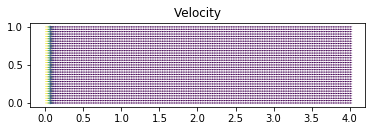

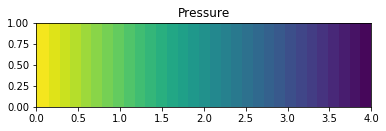

Time t = 1.0164659979556614


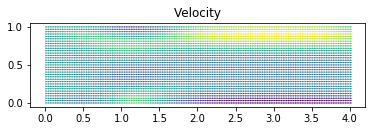

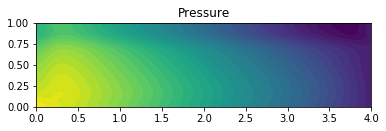

Time t = 2.010834908999242


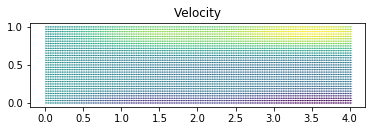

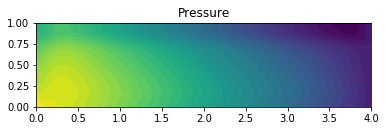

Time t = 3.0052038200428326


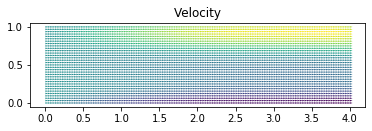

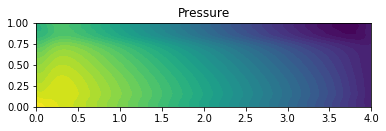

Time t = 4.021669817998503


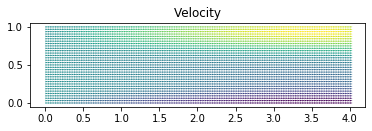

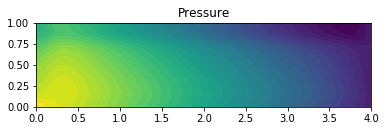

Time t = 5.016038729042093


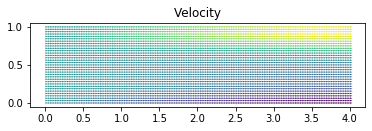

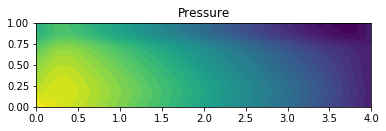

Time t = 6.010407640085684


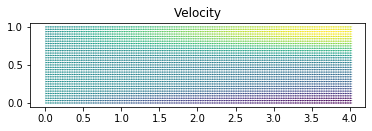

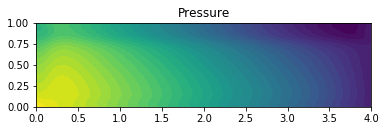

Time t = 7.004776551129274


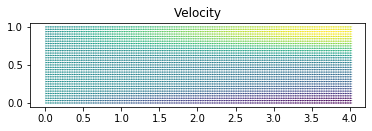

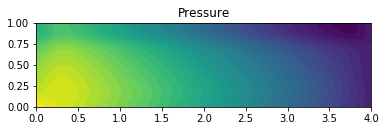

Time t = 8.021242549084944


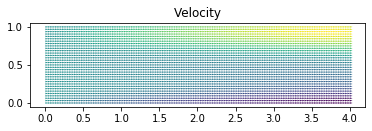

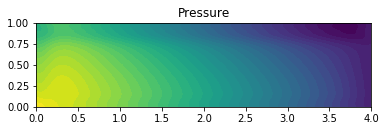

Time t = 9.015611460128534


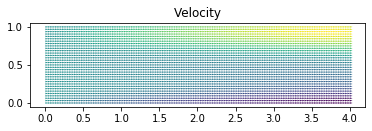

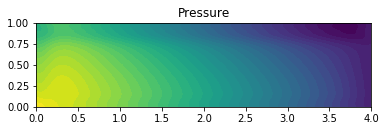

results-BNS/
results-BNS/p000007.vtu
results-BNS/u000002.vtu
results-BNS/u000006.vtu
results-BNS/p000005.vtu
results-BNS/p.pvd
results-BNS/u000004.vtu
results-BNS/p000002.vtu
results-BNS/u000007.vtu
results-BNS/p000000.vtu
results-BNS/u000001.vtu
results-BNS/p000003.vtu
results-BNS/u.pvd
results-BNS/p000004.vtu
results-BNS/p000006.vtu
results-BNS/u000005.vtu
results-BNS/u000008.vtu
results-BNS/u000009.vtu
results-BNS/p000001.vtu
results-BNS/p000008.vtu
results-BNS/p000009.vtu
results-BNS/u000000.vtu
results-BNS/u000003.vtu


In [62]:
!rm results-BNS/*

# Time stepping 
T = 10
t = dt
while t < T + DOLFIN_EPS:

    #s = 'Time t = ' + repr(t) 
    #print(s)

    # Solve non-linear problem 
    k = 0
    while k < num_nnlin_iter: 
        
        # Assemble matrix and vector 
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute solution 
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble matrix and vector
        Ap = assemble(ap) 
        bp = assemble(Lp)

        # Compute solution 
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        k += 1

    if t > plot_time:     
        
        s = 'Time t = ' + repr(t) 
        print(s)
    
        # Save solution to file
        file_u << u1
        file_p << p1

        # Plot solution
        plt.figure()
        plot(u1, title="Velocity")

        plt.figure()
        plot(p1, title="Pressure")

        plot_time += T/plot_freq
        
        plt.show()

    # Update time step
    u0.assign(u1)
    t += dt

plt.show()

!tar -czvf results-BNS.tar.gz results-BNS
files.download('results-BNS.tar.gz')